# Project 4: Predict West Nile Virus
### Section 2: Trap & Spray Data Cleaning & EDA

## Problem Statement

1. As an employee of Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE), we are tasked to better understand the mosquito population and advise on appropriate interventions which are beneficial and cost-effective for the city.


2. Through this project, we hope to:
- Identify features which are most important to predict presence of West Nile Virus (which can be done by ranking the coefficients of each feature in a logistic regression model)
- Predict the probability of West Nile Virus by location to provide decision makers an effective plan to deploy pesticides throughout the city, which consequently can help to reduce cost.

## Import Libraries

In [2]:
#!pip install shapely
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import geometry
from shapely.geometry import Point, Polygon
import geopandas as gpd
from datetime import timedelta
import math
import datetime as dt

In [3]:
# Set chart style
plt.style.use('fivethirtyeight')

## Load Data

In [4]:
# Load datasets
traintest_data = pd.read_csv('../data/data_traintest.csv', index_col='Unnamed: 0')
spray = pd.read_csv('../data/data_spray.csv', index_col='Unnamed: 0')

In [5]:
# Check columns and null values
traintest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126799 entries, 0 to 126798
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dataset                 126799 non-null  object 
 1   date                    126799 non-null  object 
 2   address                 126799 non-null  object 
 3   species                 126799 non-null  object 
 4   block                   126799 non-null  int64  
 5   street                  126799 non-null  object 
 6   trap                    126799 non-null  object 
 7   addressnumberandstreet  126799 non-null  object 
 8   latitude                126799 non-null  float64
 9   longitude               126799 non-null  float64
 10  addressaccuracy         126799 non-null  int64  
 11  nummosquitos            10506 non-null   float64
 12  wnvpresent              10506 non-null   float64
 13  year                    126799 non-null  int64  
 14  month               

In [6]:
# Check columns and null values
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14835 entries, 0 to 14834
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       14835 non-null  object 
 1   time       14251 non-null  object 
 2   latitude   14835 non-null  float64
 3   longitude  14835 non-null  float64
 4   year       14835 non-null  int64  
 5   month      14835 non-null  int64  
 6   week       14835 non-null  int64  
 7   dayofweek  14835 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.0+ MB


In [7]:
# Convert date column to datetime type 
traintest_data['date'] = pd.to_datetime(traintest_data['date'])
spray['date'] = pd.to_datetime(spray['date'])

In [8]:
# Split train test data as mosquito count is only in train data
train = traintest_data[traintest_data['dataset']=='train'].copy()
test = traintest_data[traintest_data['dataset']=='test'].copy()

### Spray Data

In [9]:
# There are 9 NaN values for timing of spray. 
# We will drop this column as we would not be using this column.
spray.drop(columns='time', inplace=True)

### Train Test Data

#### Duplicate rows

According to the Data Description on Kaggle: "These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50."

We will first check for rows that are duplicates that are not 50

In [10]:
train.shape

(10506, 17)

In [11]:
# There are 106 rows that are duplicates that are not nummosquito = 50
train[((train['nummosquitos']!=50) & train.duplicated())].head()

,dataset,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent,year,month,week,dayofweek
99,train,2007-06-26,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1.0,0.0,2007,6,26,1
512,train,2007-07-18,"3300 West Randolph Street, Chicago, IL 60612, USA",CULEX RESTUANS,33,E RANDOLPH ST,T044,"3300 E RANDOLPH ST, Chicago, IL",41.883284,-87.705085,8,1.0,0.0,2007,7,29,2
819,train,2007-08-01,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,1.0,0.0,2007,8,31,2
854,train,2007-08-01,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX PIPIENS/RESTUANS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.017430,-87.687769,8,2.0,0.0,2007,8,31,2
857,train,2007-08-01,"7500 North Oakley Avenue, Chicago, IL 60645, USA",CULEX PIPIENS,75,N OAKLEY AVE,T148,"7500 N OAKLEY AVE, Chicago, IL",42.017430,-87.687769,8,1.0,0.0,2007,8,31,2


In [12]:
# Drop rows that are duplicates that are not nummosquito = 50
train = train[~((train['nummosquitos']!=50) & train.duplicated())]

In [13]:
train.columns

Index(['dataset', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'year', 'month', 'week', 'dayofweek'],
      dtype='object')

In [14]:
# Do a list of all columns except nummosquito
allcols_except_nummosquito = ['dataset', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy', 'wnvpresent', 'year', 'month', 'week', 'dayofweek']

In [15]:
# Check sum of nummosquitos
train['nummosquitos'].sum()

134321.0

In [16]:
# Check: number of rows
train.shape

(10400, 17)

In [17]:
# Sum nummosquitos for unique rows
train = train.groupby(allcols_except_nummosquito).sum().reset_index(inplace=False)

In [18]:
# Check: train_processing was summed correctly as we have the correct sum of nummosquito
train['nummosquitos'].sum()

134321.0

In [19]:
# Check: train_processing was summed correctly as we have the correct rows
train.shape

(8610, 17)

In [20]:
test.shape

(116293, 17)

In [21]:
test.duplicated().sum()

1533

In [22]:
test.drop_duplicates(inplace=True)

We have dropped 106 duplicate rows in Train and 1533 rows in Test, and combined 1,790 rows in Train.

In [23]:
traintest = pd.concat([train,test], axis=0)

#### Trap, Address and Location
Check for consistency across Trap, Address and Location columns

In [24]:
# Description of the number of times each trap appears in the dataset
traintest.loc[traintest['dataset'] == 'train', 'trap'].value_counts().describe()

count    136.000000
mean      63.308824
std       43.907734
min        2.000000
25%       22.000000
50%       61.000000
75%       98.500000
max      182.000000
Name: trap, dtype: float64

In [25]:
# Description of the number of times each trap appears in the dataset
traintest.loc[traintest['dataset'] == 'test', 'trap'].value_counts().describe()

count     149.000000
mean      770.201342
std        87.753261
min       760.000000
25%       760.000000
50%       760.000000
75%       760.000000
max      1520.000000
Name: trap, dtype: float64

Most traps appear 760 times in the test dataset, but there are two that appear twice that number, 1520 times.

We would check for non-unique addresses to confirm if these are duplicates or error

In [26]:
# Description of the number of times each trap appears in the dataset
traintest.loc[traintest['dataset'] == 'test', 'trap'].value_counts().loc[lambda x: x>760]

T009    1520
T035    1520
Name: trap, dtype: int64

In [27]:
# Count unique rows of trap name, address, and location
unique_address = pd.DataFrame(traintest[['trap','block','address','street',
                       'addressnumberandstreet','latitude',
                       'longitude','addressaccuracy']].value_counts())

In [28]:
# Select traps that have more than one address location combination
repeat_traps = unique_address.value_counts('trap').loc[lambda x: x>1]

In [29]:
# View traps that have more than one address location combination
# Add dataset column to unique_address
unique_address = pd.DataFrame(traintest[['trap','dataset', 'block','address','street',
                       'addressnumberandstreet','latitude',
                       'longitude','addressaccuracy']].value_counts())
unique_address.loc[repeat_traps.index.tolist()]

0
trap dataset block address                                          street         addressnumberandstreet           latitude  longitude  addressaccuracy     
T009 test    91    9100 West Higgins Road, Rosemont, IL 60018, USA   W HIGGINS RD  9100  W HIGGINS RD, Chicago, IL  41.992478 -87.862995 8                760
                   9100 West Higgins Avenue, Chicago, IL 60656, USA  W HIGGINS AVE 9100  W HIGGINS AVE, Chicago, IL 41.981964 -87.812827 8                760
     train   91    9100 West Higgins Road, Rosemont, IL 60018, USA   W HIGGINS RD  9100  W HIGGINS RD, Chicago, IL  41.992478 -87.862995 8                 70
                   9100 West Higgins Avenue, Chicago, IL 60656, USA  W HIGGINS AVE 9100  W HIGGINS AVE, Chicago, IL 41.981964 -87.812827 8                 27
T035 test    30    3000 South Hoyne Avenue, Chicago, IL 60608, USA   S HOYNE AVE   3000  S HOYNE AVE, Chicago, IL   41.836644 -87.677737 8                760
             51    5100 West 72nd Street, Chicago, IL 60638, USA     W 72ND ST     5100  W 72ND ST, Chicago, IL     41.763733 -87.742302 8                760
     train   51    5100 West 72nd Street, Chicago, IL 60638, USA     W 72ND ST     5100  W 72ND ST, Chicago, IL     41.763733 -87.742302 8                 45
             30    3000 South Hoyne Avenue, Chicago, IL 60608, USA   S HOYNE AVE   3000  S HOYNE AVE, Chicago, IL   41.836644 -87.677737 8                 27

The same traps that have 1520 rows in the test data appears again in our non-unique address analysis, having different address and location coordinates. Hence its probable that these are seperate traps, probably satelite traps.

In [30]:
# Select dates that have two different coordinates
# Step 1: Select traps of interest and get list of unique rows
duplicate_check1 = traintest.loc[traintest['trap'].isin(['T009','T035']),
                                 ['date','trap','latitude','longitude']].value_counts()
display(duplicate_check1)

date        trap  latitude   longitude 
2010-09-13  T009  41.981964  -87.812827    8
2012-06-08  T035  41.836644  -87.677737    8
2012-07-19  T035  41.836644  -87.677737    8
                  41.763733  -87.742302    8
            T009  41.992478  -87.862995    8
                                          ..
2009-06-12  T009  41.992478  -87.862995    1
2013-09-06  T035  41.763733  -87.742302    1
2013-09-19  T009  41.992478  -87.862995    1
2013-09-26  T009  41.992478  -87.862995    1
2007-06-05  T009  41.981964  -87.812827    1
Length: 476, dtype: int64

In [31]:
# Select dates that have two different coordinates
# Step 2: Select dates where traps have more than one latitude and longitude
duplicate_check2 = duplicate_check1.reset_index().drop(columns=0)[['date','trap']] \
                        .value_counts().loc[lambda x: x>1]
duplicate_check2

date        trap
2010-09-16  T035    2
2010-09-23  T009    2
2010-09-24  T009    2
            T035    2
2010-10-01  T009    2
                   ..
2010-06-25  T035    2
2010-06-28  T035    2
2010-06-02  T009    2
2010-07-01  T009    2
            T035    2
Length: 190, dtype: int64

Furthermore these traps had readings in both locations on the same day. We propose to rename one of the trap location by adding a letter to the existing trap label.

In [32]:
# Check if T009 already exists
traintest[traintest['trap']=='T009A']

,dataset,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,wnvpresent,year,month,week,dayofweek,nummosquitos


In [33]:
# Check if T305A already exists
traintest[traintest['trap']=='T035A']

,dataset,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,wnvpresent,year,month,week,dayofweek,nummosquitos


In [34]:
# Rename trap rows with different address
traintest.loc[(traintest['latitude']==41.981964)&(traintest['longitude']==-87.812827),'trap'] = 'T009A'

In [35]:
# Rename trap rows with different address
traintest.loc[(traintest['latitude']==41.763733)&(traintest['longitude']==-87.742302),'trap'] = 'T035A'

In [36]:
# Drop address related columns
traintest.drop(columns=['address', 'street','addressnumberandstreet','addressaccuracy','block'], 
               inplace=True, errors='ignore')

#### Mosquito categories

We observe that there are 3 similar categories of mosquitoes, `CULEX PIPIENS/RESTUANS`, `CULEX PIPIENS`, and `CULEX RESTUANS`. From its name, it suggests that the second and third may be subsets of the first.

We observe from the sum of number of mosquitos by category that the sum of `CULEX PIPIENS/RESTUANS`, `CULEX PIPIENS`, and `CULEX RESTUANS`

In [37]:
# Split train test data as mosquito count is only in train data
train = traintest[traintest['dataset']=='train'].copy()
test = traintest[traintest['dataset']=='test'].copy()

In [38]:
# Inspect count of species
train.groupby(['species'])['nummosquitos'].sum()

species
CULEX ERRATICUS               7.0
CULEX PIPIENS             44488.0
CULEX PIPIENS/RESTUANS    65841.0
CULEX RESTUANS            23326.0
CULEX SALINARIUS            144.0
CULEX TARSALIS                7.0
CULEX TERRITANS             508.0
Name: nummosquitos, dtype: float64

In [39]:
# Inspect count of species by wnvpresent
train.groupby(['species','wnvpresent'])['nummosquitos'].sum()

species                 wnvpresent
CULEX ERRATICUS         0.0               7.0
CULEX PIPIENS           0.0           37759.0
                        1.0            6729.0
CULEX PIPIENS/RESTUANS  0.0           58739.0
                        1.0            7102.0
CULEX RESTUANS          0.0           22659.0
                        1.0             667.0
CULEX SALINARIUS        0.0             144.0
CULEX TARSALIS          0.0               7.0
CULEX TERRITANS         0.0             508.0
Name: nummosquitos, dtype: float64

In [40]:
# Drop rows for categories with total few number of mosquitos
train = train[train['species']
                 .isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS'])]
test = test[test['species']
                 .isin(['CULEX PIPIENS','CULEX PIPIENS/RESTUANS','CULEX RESTUANS'])]

In [41]:
# Select columns to remain along the index in pivot table
select_cols = ['dataset', 'date', 'trap', 'latitude', 
                              'longitude','wnvpresent', 'year', 'month', 'week', 'dayofweek']

In [42]:
# Pivot table 
train_pivot = train.pivot_table(index = select_cols, 
                                           columns='species', 
                                           values='nummosquitos',
                                           fill_value=0).reset_index()

In [43]:
# Create a column to sum the mosquito counts of 'CULEX PIPIENS' and'CULEX RESTUANS'
train_pivot['sum_species'] = train_pivot['CULEX PIPIENS'] + train_pivot['CULEX RESTUANS']

In [44]:
# Create a column to find the difference between the mosquito counts of 
# 'CULEX PIPIENS/RESTUANS' and the sum of 'CULEX PIPIENS' and'CULEX RESTUANS'
train_pivot['compare'] = train_pivot['sum_species'] - train_pivot['CULEX PIPIENS/RESTUANS']

In [45]:
# Count of zero differences
train_pivot[(train_pivot['CULEX PIPIENS/RESTUANS']!= 0)]['compare'].value_counts()

-1      555
-2      361
 0      293
-3      273
 1      193
       ... 
 69       1
-797      1
-62       1
-105      1
 33       1
Name: compare, Length: 238, dtype: int64

There doesnt seem to be systematic duplication of data. Only 293 rows out of 3899 or 8% had zero differences and non-zero mosquito counts. Also, there is low correlation between the rows for both numerical values and count (existence of mosquitoes) are low.

Hence we propose to leave the data as it is.

In [46]:
traintest = pd.concat([train,test], axis=0)

### Export CSV

In [47]:
traintest.to_csv('../data/processed_traintest.csv')

In [48]:
spray.to_csv('../data/processed_spray.csv')

#### Joining TrainTest and Spray dataframes

Note: the csv is exported before this as there is code in section 3 that joins the traintest data and spray dataframe

In [49]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14835 entries, 0 to 14834
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14835 non-null  datetime64[ns]
 1   latitude   14835 non-null  float64       
 2   longitude  14835 non-null  float64       
 3   year       14835 non-null  int64         
 4   month      14835 non-null  int64         
 5   week       14835 non-null  int64         
 6   dayofweek  14835 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 927.2 KB


In [50]:
spray['date'].value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: date, dtype: int64

In [51]:
# create list of dates
spray_dates = spray['date'].value_counts().index

In [52]:
# create function to return 1 if trap received spray within 1.1km (0.01 degree of latitude) within the past 7 day
def near_spray(trap_lat, trap_long, date, distance=0.01, days=7):
    
    """ Input latitude and longitude of trap and date of interest. Return 1 if trap received spray 
    within 1.1km (0.01 degree of latitude) within the past 7 day
    date = date that trap was checked
    
    """
    
    trap_loc = geometry.Point(trap_lat, trap_long)

    # create your circle buffer from trap_loc
    circle_buffer = trap_loc.buffer(distance)

    for lat, long in zip(list(spray.loc[(spray['date'] <= date) & 
                                        (spray['date'] >= (date - timedelta(days=days))),'latitude']), 
                         list(spray.loc[(spray['date'] <= date) & 
                                        (spray['date'] >= (date - timedelta(days=days))),'longitude'])):
        spray_loc = geometry.Point(lat, long)

        # and you can then check if the other point lies within
        if spray_loc.within(circle_buffer):
            return 1

In [53]:
# create a column is_spray - 1 if trap received spray within 1.1km (0.01 degree of latitude) within the past 7 day
traintest['is_spray'] = traintest.apply(
    lambda row: near_spray(row['latitude'], row['longitude'], row['date'], distance=0.01, days=7),
    axis = 1
)

In [54]:
traintest['latitude'][0]

41.867108

In [55]:
# number of traps sprayed within 1.1km (0.01 degree of latitude) within the past 7 days
traintest.loc[traintest['is_spray']==1,['date', 'trap', 'is_spray']].groupby('date').count()

,trap,is_spray
date,,
2011-09-12,2,2
2013-07-19,12,12
2013-07-25,1,1
2013-08-01,3,3
2013-08-08,3,3
2013-08-15,13,13
2013-08-22,22,22
2013-08-29,14,14
2013-09-06,2,2


In [56]:
traintest['is_spray'].fillna(0, inplace=True)

### Export CSV

In [57]:
traintest.shape

(51339, 13)

### Translate Location Data for Trap location in Train & Test and Spray Locations

We would use Shapely and Geopandas packages to process and visualize location data

In [58]:
# Define Coordinate Reference System type (according to the map boundary files)
crs = {'init':'epsg:4326'}

In [59]:
# Trap Locations
# Create column of Shapely Point objects of the location of each trap
geometry = [Point(xy) for xy in zip(traintest['longitude'], traintest['latitude'])]
# Transform traintest into a GeoDataFrame
geo_traintest = gpd.GeoDataFrame(traintest,
                         crs=crs,
                          geometry=geometry
                         )

In [60]:
# Spray Locations
# Create column of Shapely Point objects of the location of each spray
spray_location = [Point(xy) for xy in zip(spray['longitude'], spray['latitude'])]
# Transform traintest into a GeoDataFrame
geo_spray = gpd.GeoDataFrame(spray,
                             crs=crs,
                             geometry=spray_location
                            )

In [61]:
# Weather Stations
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
stations = {'Latitude':[41.995,41.786], 'Longitude':[-87.933,-87.752]}

In [62]:
# Create column of Shapely Point objects of the location of each weather station
station_location = [Point(xy) for xy in zip(stations['Longitude'], stations['Latitude'])]
# Transform to GeoDataFrame
geo_stations = gpd.GeoDataFrame(stations,
                         crs=crs,
                          geometry=station_location
                         )

In [63]:
# import community and precinct map boundary files
community_map = gpd.read_file('../data/Boundaries - Community Areas (current)/geo_export_696264d7-9f06-473f-a0d2-238466734f0f.shp')
precinct_map = gpd.read_file('../data/Precincts (current)/geo_export_c00eb2b5-21d4-4f5f-be2b-399758f8fb18.shp')

### EDA

In [64]:
# Create masks for categorical and numerical features
category_columns = [key for key, val in geo_traintest.iteritems() 
                    if geo_traintest.dtypes[key] == 'object']
numerical_columns = [key for key, val in geo_traintest.iteritems() 
                     if (geo_traintest.dtypes[key] == 'int64') or 
                     (geo_traintest.dtypes[key] == 'float64') or
                     (geo_traintest.dtypes[key] == 'datetime64[ns]')
                    ]
print(len(category_columns))
print(len(numerical_columns))

3
10


In [65]:
list(geo_traintest)

['dataset',
 'date',
 'species',
 'trap',
 'latitude',
 'longitude',
 'wnvpresent',
 'year',
 'month',
 'week',
 'dayofweek',
 'nummosquitos',
 'is_spray',
 'geometry']

In [66]:
yr07 = geo_traintest[geo_traintest["year"]==2007]

#### Trap prevalence of WNV

In [67]:
geo_traintest.groupby('year')['wnvpresent'].mean()

year
2007    0.070182
2008         NaN
2009    0.010096
2010         NaN
2011    0.029709
2012         NaN
2013    0.097263
2014         NaN
Name: wnvpresent, dtype: float64

#### Trap prevalence of WNV

In [71]:
prev_07 = 0.070182
prev_09 = 0.010096
prev_11 = 0.029709
prev_13 = 0.097263

#### Population Size
https://www.biggestuscities.com/il/2007
Gov data on population count
https://www.opendatanetwork.com/entity/1600000US1714000/Chicago_IL/demographics.population.count?year=2011

In [72]:
pop_2007 = 2_811_035
pop_2009 = 2_824_064
pop_2011 = 2_700_741
pop_2013 = 2_706_101

#### Number of people with WNV by years https://www.chicago.gov/content/dam/city/depts/cdph/food_env/general/West_Nile_Virus/WNV_2018databrief_FINALJan102019.pdf
Previous infected number of people
https://www.chicago.gov/content/dam/city/depts/cdph/statistics_and_reports/CDInfo_2013_JULY_WNV.pdf

In [73]:
inf_2007 = 10
inf_2009 = 1
inf_2011 = 8
inf_2013 = 37

#### Rate of infection by proportion of traps that had WNV

The prevalence of traps with WNV multiplied by the number of people population in Chicago is not sufficient to tell us how many people will get infected with WNV. When multiplied by an infection rate, we will be able to get the number of infected people. Therefore, infection rate is the number of infected people, divided by prevalence rate of that year, and the population of that year.

In [74]:
a = inf_2007 / (prev_07 * pop_2007)
a

5.068833276556648e-05

In [75]:
b = inf_2009 / (prev_09 * pop_2009)
b

3.507325909316161e-05

In [76]:
c = inf_2011 / (prev_11 * pop_2011)
c

9.970547703884652e-05

In [77]:
d  = inf_2013 / (prev_13 * pop_2013)
d

0.0001405756374071024

We will take the average of these 4 years to get an estimated infection rate in Chicago.

In [78]:
infection_rate = (a+b+c+d)/4
infection_rate

8.151067657616925e-05

## To fill up
inf_2014 = infection_rate * prev_14 * pop_2014

This will give the number of people infected in 2014

#### Assuming 2014 prevalence rate is 0.05

In [90]:
pop_2014 = 2_712_608

In [91]:
prev_14 = 0.05

In [92]:
inf_2014 = infection_rate * prev_14 * pop_2014
inf_2014

11.055325668296465

Science article on medical costs of WNV
https://www.sciencedaily.com/releases/2014/02/140210184713.htm#:~:text=In%20a%20study%20of%20the,care%20expenditures%20and%20lost%20productivity
Economic costs of WNV
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/
Robin and crows being vectors
https://ij-healthgeographics.biomedcentral.com/articles/10.1186/1476-072X-6-10

#### Medical cost of severe cases-

Severe cases are known as WNND and occurs for every 1 in 150 cases.

In [121]:
#Per person with WNND 
wnnd_cost = (2_140_409+484_800) / 46
wnnd_cost

57069.760869565216

#### Medical cost of normal cases- 

West nile fever (WNF) is when WNV is symptomatic, resulting in influenza-like symptoms such as fever), and occurs in 20% of those infected
These are the people who will get their cases reported- close to 80% of people who get WNV are asymptomatic and never get accounted for.

In [122]:
physician_cost = 167
diagnostic_test = 135

#productivity costs for assumed 5 days of missed work
prod_loss = 955

normal_case_cost = physician_cost + diagnostic_test + prod_loss
normal_case_cost

1257

Estimated costs for each person that is infected with WNV, and reports
Therefore, those reported are either having WNF or WNND. The odds of these diseases and their costs will be tabulated.

In [123]:
#Estimated cost of each person
# Probability of getting a WNF is 0.2 and 
# probability of getting WNND is 1/150
denominator_of_odds = (0.2 + 1/150)
cost_wnv_individual = normal_case_cost * (0.2/denominator_of_odds) + wnnd_cost * ((1/150)/denominator_of_odds)
cost_wnv_individual

3057.4116409537164

In [124]:
37_088 * cost_wnv_individual / 1_000_000

113.39328293969145

West Nile Virus costs
https://www.sciencedaily.com/releases/2014/02/140210184713.htm#:~:text=In%20a%20study%20of%20the,care%20expenditures%20and%20lost%20productivity

In [125]:
cost_indiv = 778_000_000 / 37_088
cost_indiv

20977.13546160483

This is a confluence of factors such as the physician's cost, diagnostic test cost, and productivity costs.

#### Cost of spraying

Type of spray: Zenivex
https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_living/news/2021/august/city-to-spray-insecticide-wednesday-to-kill-mosquitoes.html

In [126]:
geo_traintest.groupby('year')['wnvpresent'].mean()

year
2007    0.070182
2008         NaN
2009    0.010096
2010         NaN
2011    0.029709
2012         NaN
2013    0.097263
2014         NaN
Name: wnvpresent, dtype: float64

In [127]:
area_chicago = 606.1 * 10_000 * 10_000

In [128]:
#this percentage of chicago is exposed to WNV possibility as they are near the traps with WNV presence
area_spray_2014 = area_chicago * prev_14 #prev14 means the prevalence of mosquitoes within traps in 2014
area_spray_2014

3030500000.0

In [129]:
3030500000.0 / 10_000 / 10_000

30.305

In [130]:
#converting acres to m^2
acre_to_m2 = 4046.86

Spray in areas (65% sensitivity)

It costs 0.67c to spray one acre of land according to this information by for Zenivex, the government chosen pesticide for mosquito control due to its non-toxicity to humans

In [131]:
cost_to_spray = 0.67

In [132]:
#cost to spray per m2
cost_to_spray_m2 = 0.67 / acre_to_m2

In [133]:
area_spray_2014 * cost_to_spray_m2

501730.97166692204

Number of lives impacted 

In [134]:
inf_2014 * 0.65

7.185961684392702

Cost of lives impacted

In [135]:
7.180807559190986 * cost_indiv

150632.77289286527

In [136]:
7.180807559190986 * cost_wnv_individual

21954.68462291896

[Text(0.5, 1.0, 'Rate of WNV presence by year')]

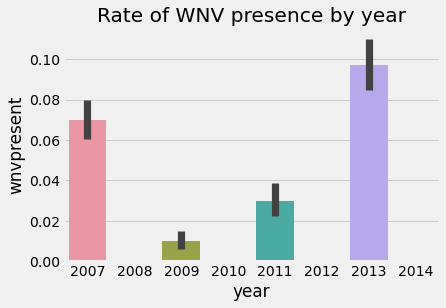

In [153]:
# Mean of WNV present by year (adjusting for the difference in number of readings taken)
sns.barplot(data=geo_traintest, x='year', y='wnvpresent', estimator=np.mean).set(
    title='Rate of WNV presence by year')

Text(0.5, 1.0, 'Count of WNV presence by trap')

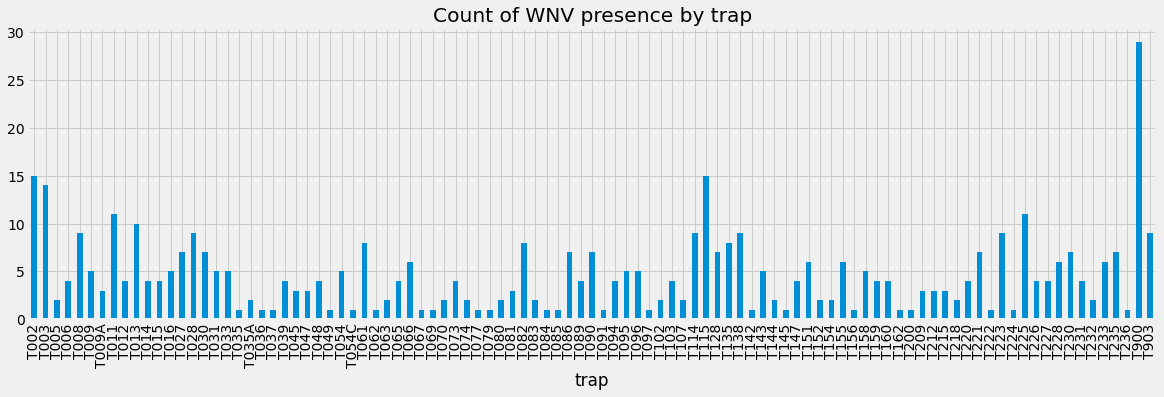

In [154]:
# Traps by number of WNV present readings
fig,ax = plt.subplots(figsize=(18,5))
geo_traintest.groupby('trap').sum()['wnvpresent'].loc[lambda x: x>0].plot.bar()
plt.title('Count of WNV presence by trap')

Text(0.5, 1.0, 'Rate of WNV presence by trap')

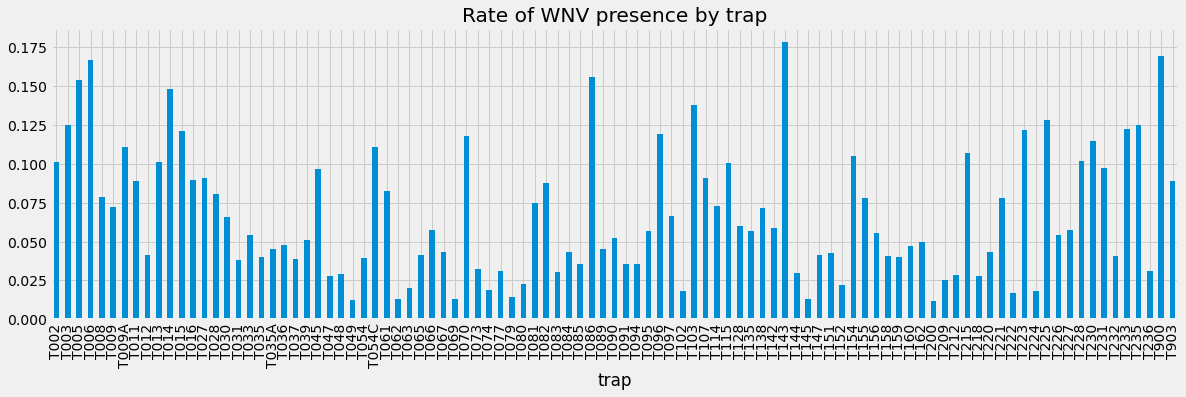

In [155]:
# Traps by number of WNV present readings
fig,ax = plt.subplots(figsize=(18,5))
geo_traintest.groupby('trap').mean()['wnvpresent'].loc[lambda x: x>0].plot.bar()
plt.title('Rate of WNV presence by trap')

In [156]:
# Filter traps that ever had WNV present
wnv_traps = geo_traintest.groupby('trap').sum()['wnvpresent'].loc[lambda x: x>0].index
wnv_filtered = geo_traintest[(geo_traintest['dataset']=='train') &
                (geo_traintest['trap'].isin(wnv_traps))]

In [157]:
# Pivot by year
pivot_by_year = pd.pivot_table(wnv_filtered,index=wnv_filtered['trap'],columns=wnv_filtered['date'].dt.year,
               values='wnvpresent',aggfunc=['count'])
pivot_by_year.isna().sum()
# Table: number of traps with WNV per year

       date
count  2007    18
       2009    33
       2011    27
       2013    31
dtype: int64